In [1]:
# importing the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# for evaluating the model
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
# loading dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,file_name,width,height,x1,y1,x2,y2,category
0,003_0001.png,85,76,20,10,67,58,0
1,003_0002.png,98,92,20,17,83,75,0
2,003_0003.png,122,112,24,16,102,93,0
3,003_0004.png,72,62,13,7,59,52,0
4,003_0005.png,116,102,24,15,95,87,0


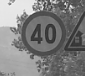

In [3]:
#針對train_data
#存放resize過後的image
train_list_images = []
#存放label
train_list_label = []
folder = "./images"
for value in train_data.iterrows():
    img = Image.open(os.path.join(folder, value[1]['file_name']))
    img = img.convert('L')
    train_list_images.append(img)

train_list_label = train_data['category'].values
train_list_images[0]

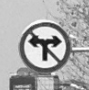

In [4]:
#存放resize過後的image
test_list_images = []
#存放label
test_list_label = []
for value in test_data.iterrows():
    img = Image.open(os.path.join(folder, value[1]['file_name']))
    img = img.convert('L')
    test_list_images.append(img)
test_list_label = test_data['category'].values
test_list_images[0]

In [5]:
#對數據集進行處理
class dataset(Dataset):
    def __init__(self, data, target, transform):
        self.data = data
        self.target = torch.LongTensor(target)
        self.transform = transform
    #真正讀取data的function(回傳image data跟label)
    def __getitem__(self, index):
        img, label = self.data[index], self.target[index]
        img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.data)

In [6]:
#進行前處理
batch_size = 8
train_transform = transforms.Compose([
    #將圖片大小都調成28x28
    transforms.Resize((28, 28)),
    #轉成tensor
    transforms.ToTensor(),
    #進行正規化
    transforms.Normalize(mean=[0.485], std=[0.229])
])
test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
train_dataset = dataset(train_list_images, train_list_label, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = dataset(test_list_images, test_list_label, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


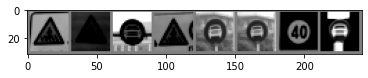

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#隨機從train_data中挑幾張圖片
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
#定義CNN的architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(
            #第一次Concolution
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.03),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #第二次Concolution
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fully_connect =  nn.Sequential(
            nn.Linear(128*7*7, 2)
        )
        self.output = nn.Sequential(
            nn.Linear(2, 7)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(1)
        x = self.fully_connect(x)
        plot = x
        x = self.output(x)
        return x, plot

CNN_model = Net()
#定義loss function和optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_model.parameters(), lr=0.001, momentum=0.9)
train_losses = []
val_losses = []
if torch.cuda.is_available():
    CNN_model.cuda()
    loss = loss.cuda()

In [9]:
print(torch.cuda.is_available())
device = torch.device("cuda") # Should be true

True


### 1.(b)

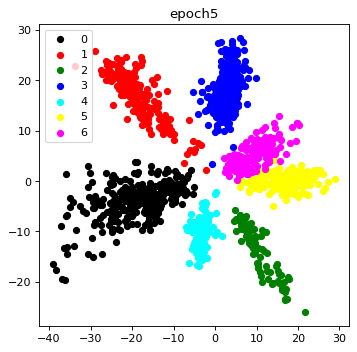

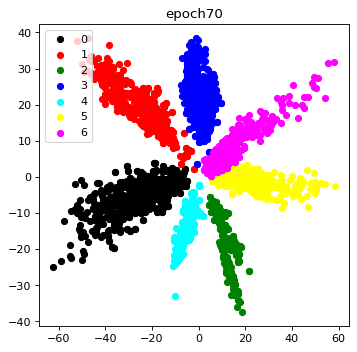

Finished Training


In [10]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
label0X, label0Y, label1X, label1Y, label2X, label2Y, label3X, label3Y = [], [], [], [], [], [], [], []
label4X, label4Y, label5X, label5Y, label6X, label6Y = [], [], [], [], [], []
train_predictions = []
plot_dot = []
#訓練神經網路
epoch_counter = 80
for epoch in range(epoch_counter):
    #print('running epoch: {}'.format(epoch+1))
    correct = 0
    total = 0
    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0
    CNN_model.train()
    for i, data in enumerate(train_dataloader, 0):     
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, plot = CNN_model(inputs)
        #計算loss 
        Loss = loss(outputs, labels.long())
        Loss.backward()
        optimizer.step()
        train_loss += Loss.item()        
         # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #存預測準確數量
        correct += (predicted == labels.cuda()).sum().item()  
        
        #存第5個和第70個epoch要畫latent feature distributions的資料
        if(epoch == 4):
            plot_dot.extend(plot.detach().cpu().tolist())
            train_predictions.extend(predicted.detach().cpu().tolist())
        elif(epoch == 69):
            plot_dot.extend(plot.detach().cpu().tolist())
            train_predictions.extend(predicted.detach().cpu().tolist())
            
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracy.append(correct/total)
    
    #畫latent feature distributions
    if(epoch == 4):
        for i, category in enumerate(train_predictions):
            if train_predictions[i] == 0:
                label0X.append(plot_dot[i][0])
                label0Y.append(plot_dot[i][1])
            elif train_predictions[i] == 1:
                label1X.append(plot_dot[i][0])
                label1Y.append(plot_dot[i][1])
            elif train_predictions[i] == 2:
                label2X.append(plot_dot[i][0])
                label2Y.append(plot_dot[i][1])
            elif train_predictions[i] == 3:
                label3X.append(plot_dot[i][0])
                label3Y.append(plot_dot[i][1])
            elif train_predictions[i] == 4:
                label4X.append(plot_dot[i][0])
                label4Y.append(plot_dot[i][1])
            elif train_predictions[i] == 5:
                label5X.append(plot_dot[i][0])
                label5Y.append(plot_dot[i][1])
            elif train_predictions[i] == 6:
                label6X.append(plot_dot[i][0])
                label6Y.append(plot_dot[i][1])
            elif train_predictions[i] == 7:
                label7X.append(plot_dot[i][0])
                label7Y.append(plot_dot[i][1])
        plt.figure(figsize=(5, 5), dpi=80)
        axes = plt.subplot(111)
        axes.set_title('epoch5')  
        label0 = axes.scatter(label0X, label0Y, s=30, c="black")
        label1 = axes.scatter(label1X, label1Y, s=30, c="red")
        label2 = axes.scatter(label2X, label2Y, s=30, c="green")
        label3 = axes.scatter(label3X, label3Y, s=30, c="blue")
        label4 = axes.scatter(label4X, label4Y, s=30, c="cyan")
        label5 = axes.scatter(label5X, label5Y, s=30, c="yellow")
        label6 = axes.scatter(label6X, label6Y, s=30, c="magenta")
        axes.legend((label0, label1, label2, label3, label4, label5, label6), ("0", "1", "2", "3", "4", "5", "6"), loc=2)
        plt.show()
    if(epoch == 69):
        for i, category in enumerate(train_predictions):
            if train_predictions[i] == 0:
                label0X.append(plot_dot[i][0])
                label0Y.append(plot_dot[i][1])
            elif train_predictions[i] == 1:
                label1X.append(plot_dot[i][0])
                label1Y.append(plot_dot[i][1])
            elif train_predictions[i] == 2:
                label2X.append(plot_dot[i][0])
                label2Y.append(plot_dot[i][1])
            elif train_predictions[i] == 3:
                label3X.append(plot_dot[i][0])
                label3Y.append(plot_dot[i][1])
            elif train_predictions[i] == 4:
                label4X.append(plot_dot[i][0])
                label4Y.append(plot_dot[i][1])
            elif train_predictions[i] == 5:
                label5X.append(plot_dot[i][0])
                label5Y.append(plot_dot[i][1])
            elif train_predictions[i] == 6:
                label6X.append(plot_dot[i][0])
                label6Y.append(plot_dot[i][1])
            elif train_predictions[i] == 7:
                label7X.append(plot_dot[i][0])
                label7Y.append(plot_dot[i][1])
        plt.figure(figsize=(5, 5), dpi=80)
        axes = plt.subplot(111)
        axes.set_title('epoch70')  
        label0 = axes.scatter(label0X, label0Y, s=30, c="black")
        label1 = axes.scatter(label1X, label1Y, s=30, c="red")
        label2 = axes.scatter(label2X, label2Y, s=30, c="green")
        label3 = axes.scatter(label3X, label3Y, s=30, c="blue")
        label4 = axes.scatter(label4X, label4Y, s=30, c="cyan")
        label5 = axes.scatter(label5X, label5Y, s=30, c="yellow")
        label6 = axes.scatter(label6X, label6Y, s=30, c="magenta")
        axes.legend((label0, label1, label2, label3, label4, label5, label6), ("0", "1", "2", "3", "4", "5", "6"), loc=2)
        plt.show()
        
    correct = 0
    total = 0
    CNN_model.eval()
    for i, data in enumerate(test_dataloader, 0):     
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # forward + backward + optimize
        outputs, plot = CNN_model(inputs)
        #plot_dot = plot.cpu().numpy()
        Loss = loss(outputs, labels.long())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        
        test_loss += Loss.item()
    test_losses.append(test_loss/len(test_dataloader))
    test_accuracy.append(correct/total)
print('Finished Training')

### 1.(a)

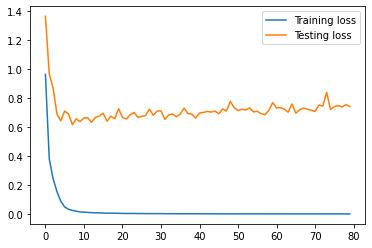

In [11]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()

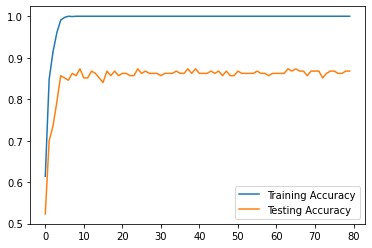

In [12]:
# plotting the training and validation loss
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

### 2.(a)

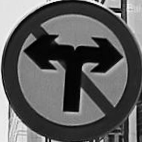

In [13]:
#針對train_data做crop
#存放resize過後的image
train_crop_images = []
folder = "./images"
for value in train_data.iterrows():
    img = Image.open(os.path.join(folder, value[1]['file_name']))
    img = img.convert('L')
    img = img.crop((value[1]['x1'], value[1]['y1'], value[1]['x2'], value[1]['y2']))
    train_crop_images.append(img)
train_crop_images[100]

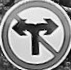

In [14]:
#針對test_data做crop
#存放resize過後的image
test_crop_images = []
folder = "./images"
for value in test_data.iterrows():
    img = Image.open(os.path.join(folder, value[1]['file_name']))
    img = img.convert('L')
    img = img.crop((value[1]['x1'], value[1]['y1'], value[1]['x2'], value[1]['y2']))
    test_crop_images.append(img)
test_crop_images[100]

In [15]:
train_crop_dataset = dataset(train_crop_images, train_list_label, train_transform)
train_crop_dataloader = DataLoader(train_crop_dataset, batch_size=batch_size, shuffle=True)
test_crop_dataset = dataset(test_crop_images, test_list_label, test_transform)
test_crop_dataloader = DataLoader(test_crop_dataset, batch_size=batch_size, shuffle=True)

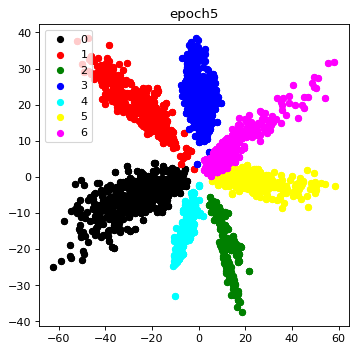

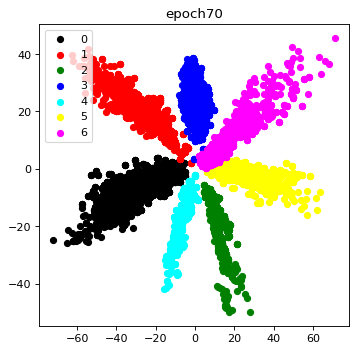

Finished Training


In [16]:
train_crop_losses = []
test_crop_losses = []
train_crop_accuracy = []
test_crop_accuracy = []
#訓練神經網路
epoch_counter = 80
for epoch in range(epoch_counter):
    correct = 0
    total = 0
    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0
    CNN_model.train()
    for i, data in enumerate(train_crop_dataloader, 0):     
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, plot = CNN_model(inputs)
        Loss = loss(outputs, labels.long())
        Loss.backward()
        optimizer.step()
        # print statistics
        train_loss += Loss.item()        
         # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        
        #存第5個和第70個epoch要畫latent feature distributions的資料
        if(epoch == 4 | epoch ==69):
            plot_dot.extend(plot.detach().cpu().tolist())
            train_predictions.extend(predicted.detach().cpu().tolist())
        
    train_crop_losses.append(train_loss/len(train_crop_dataloader))
    train_crop_accuracy.append(correct/total)
    
    #畫latent feature distributions
    if(epoch == 4):
        for i, category in enumerate(train_predictions):
            if train_predictions[i] == 0:
                label0X.append(plot_dot[i][0])
                label0Y.append(plot_dot[i][1])
            elif train_predictions[i] == 1:
                label1X.append(plot_dot[i][0])
                label1Y.append(plot_dot[i][1])
            elif train_predictions[i] == 2:
                label2X.append(plot_dot[i][0])
                label2Y.append(plot_dot[i][1])
            elif train_predictions[i] == 3:
                label3X.append(plot_dot[i][0])
                label3Y.append(plot_dot[i][1])
            elif train_predictions[i] == 4:
                label4X.append(plot_dot[i][0])
                label4Y.append(plot_dot[i][1])
            elif train_predictions[i] == 5:
                label5X.append(plot_dot[i][0])
                label5Y.append(plot_dot[i][1])
            elif train_predictions[i] == 6:
                label6X.append(plot_dot[i][0])
                label6Y.append(plot_dot[i][1])
            elif train_predictions[i] == 7:
                label7X.append(plot_dot[i][0])
                label7Y.append(plot_dot[i][1])
        plt.figure(figsize=(5, 5), dpi=80)
        axes = plt.subplot(111)
        axes.set_title('epoch5')  
        label0 = axes.scatter(label0X, label0Y, s=30, c="black")
        label1 = axes.scatter(label1X, label1Y, s=30, c="red")
        label2 = axes.scatter(label2X, label2Y, s=30, c="green")
        label3 = axes.scatter(label3X, label3Y, s=30, c="blue")
        label4 = axes.scatter(label4X, label4Y, s=30, c="cyan")
        label5 = axes.scatter(label5X, label5Y, s=30, c="yellow")
        label6 = axes.scatter(label6X, label6Y, s=30, c="magenta")
        axes.legend((label0, label1, label2, label3, label4, label5, label6), ("0", "1", "2", "3", "4", "5", "6"), loc=2)
        plt.show()
    elif(epoch == 69):
        for i, category in enumerate(train_predictions):
            if train_predictions[i] == 0:
                label0X.append(plot_dot[i][0])
                label0Y.append(plot_dot[i][1])
            elif train_predictions[i] == 1:
                label1X.append(plot_dot[i][0])
                label1Y.append(plot_dot[i][1])
            elif train_predictions[i] == 2:
                label2X.append(plot_dot[i][0])
                label2Y.append(plot_dot[i][1])
            elif train_predictions[i] == 3:
                label3X.append(plot_dot[i][0])
                label3Y.append(plot_dot[i][1])
            elif train_predictions[i] == 4:
                label4X.append(plot_dot[i][0])
                label4Y.append(plot_dot[i][1])
            elif train_predictions[i] == 5:
                label5X.append(plot_dot[i][0])
                label5Y.append(plot_dot[i][1])
            elif train_predictions[i] == 6:
                label6X.append(plot_dot[i][0])
                label6Y.append(plot_dot[i][1])
            elif train_predictions[i] == 7:
                label7X.append(plot_dot[i][0])
                label7Y.append(plot_dot[i][1])    
        plt.figure(figsize=(5, 5), dpi=80)
        axes = plt.subplot(111)
        axes.set_title('epoch70')  
        label0 = axes.scatter(label0X, label0Y, s=30, c="black")
        label1 = axes.scatter(label1X, label1Y, s=30, c="red")
        label2 = axes.scatter(label2X, label2Y, s=30, c="green")
        label3 = axes.scatter(label3X, label3Y, s=30, c="blue")
        label4 = axes.scatter(label4X, label4Y, s=30, c="cyan")
        label5 = axes.scatter(label5X, label5Y, s=30, c="yellow")
        label6 = axes.scatter(label6X, label6Y, s=30, c="magenta")
        axes.legend((label0, label1, label2, label3, label4, label5, label6), ("0", "1", "2", "3", "4", "5", "6"), loc=2)
        plt.show()
    
    correct = 0
    total = 0
    CNN_model.eval()
    for i, data in enumerate(test_crop_dataloader, 0):     
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # forward + backward + optimize
        outputs, plot = CNN_model(inputs)
        Loss = loss(outputs, labels.long())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        
        test_loss += Loss.item()
    test_crop_losses.append(test_loss/len(test_crop_dataloader))
    test_crop_accuracy.append(correct/total)
print('Finished Training')

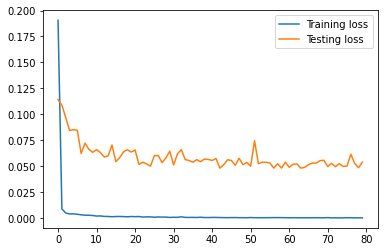

In [17]:
# plotting the training and validation loss
plt.plot(train_crop_losses, label='Training loss')
plt.plot(test_crop_losses, label='Testing loss')
plt.legend()
plt.show()

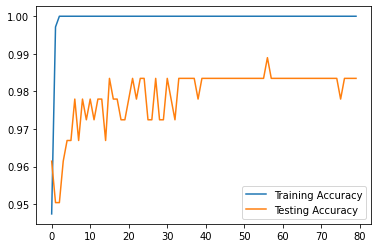

In [18]:
plt.plot(train_crop_accuracy, label='Training Accuracy')
plt.plot(test_crop_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

### 2.(b)

### 從第一題和第二題的Accuracy和Loss圖來看，有經過cropping處理的圖片一開始的Accuracy會較高, Loss會較低；兩題都不需要10個epoch即收斂；從latent feature distribution的圖來看，在第一題時，可以觀察到epoch 5和epoch 70的分布相差會比第二題的分布來得大；所以由上述得觀察，可以得到一個結論是圖片有經過cropping前處理的圖片Accuracy和Loss的表現較好。